In [1]:
import torch
import os
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import shutil
import glob
import dlib
import numpy as np
import math
from wgan_gp import *

In [2]:
image_shape = (3, 64, 64)
n_classes = 10
image_path = '../resized_emoji_challenge_128_faces'
# criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
lambda_gp = 10
g_conv_dim = 64
d_conv_dim = 64
ckpt_epoch = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_to_idx = {'angry': 0, 'clenched_teeth': 1, 'cringe': 2, 'disgust': 3, 'eye_roll': 4, 'here_we_go': 5, 'kiss': 6, 'sad': 7, 'surprise': 8, 'very_sad': 9}
idx_to_class = dict([(value, key) for key, value in class_to_idx.items()])

In [3]:
def set_all_seeds(seed):
#     random.seed(seed)
#     np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()
        
set_all_seeds(0)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, num_classes=n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(), y.float()), dim=1)
    return combined

In [4]:
# Adapted from https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def load_ckpt(checkpoint_path, gen, gen_opt, disc, disc_opt):
    # load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # initialize state_dict from checkpoint
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    
    # initialize optimizers from checkpoint
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    
    return checkpoint['epoch'], gen, disc, gen_opt, disc_opt

In [5]:
def truncated_z_sample(batch_size, z_dim, truncation=0.5, seed=None, device='cpu'):
    state = None if seed is None else np.random.RandomState(seed)
    values = truncnorm.rvs(-2, 2, size=(batch_size, z_dim), random_state=state)
    values *= truncation
    values = torch.from_numpy(values).float().to(device)
    return values

def get_input_dimensions(z_dim, image_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        image_shape: the shape of each image as (C, W, H)
        n_classes: the total number of classes in the dataset, an integer scalar
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = image_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [6]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, image_shape, n_classes)

gen = Generator(image_shape[1], generator_input_dim, g_conv_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator(discriminator_im_chan, d_conv_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        try:
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

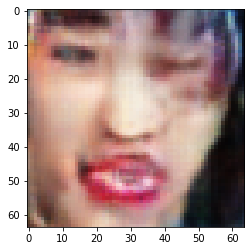

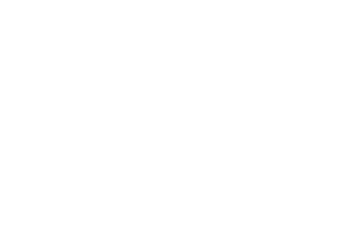

In [7]:
start_epoch, gen, disc, gen_opt, disc_opt = load_ckpt('model_ckpt/cSAWGAN-GP/epoch_120.pth.tar', gen, gen_opt, disc, disc_opt)
interpolation_noise = get_noise(1, z_dim, device=device)
emoji = 0
label = get_one_hot_labels(torch.Tensor([emoji]).long(), n_classes)
noise_and_labels = combine_vectors(interpolation_noise, label.to(device))
fake = gen(noise_and_labels)
show_tensor_images(fake, num_images=1, nrow=1)
_ = plt.axis('off')

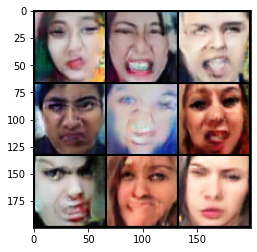

tensor([[[[ 0.6172,  0.6211,  0.5812,  ..., -0.6785, -0.5257, -0.3113],
          [ 0.6956,  0.6103,  0.4928,  ..., -0.7184, -0.4939, -0.3306],
          [ 0.6565,  0.6060,  0.4515,  ..., -0.6278, -0.5081, -0.3973],
          ...,
          [-0.7580, -0.8052, -0.8022,  ...,  0.9853,  0.9547,  0.6186],
          [-0.7396, -0.7182, -0.7367,  ...,  0.9741,  0.8610,  0.4420],
          [-0.6357, -0.6090, -0.5161,  ...,  0.9369,  0.7775,  0.3199]],

         [[ 0.4021,  0.4439,  0.4213,  ..., -0.6060, -0.4514, -0.3501],
          [ 0.5418,  0.5151,  0.3389,  ..., -0.5739, -0.3701, -0.2795],
          [ 0.5796,  0.5019,  0.3658,  ..., -0.5167, -0.3752, -0.3613],
          ...,
          [-0.5964, -0.4443, -0.4362,  ...,  0.6960,  0.4302, -0.0780],
          [-0.5668, -0.4394, -0.4385,  ...,  0.6840,  0.2132, -0.2508],
          [-0.5569, -0.4773, -0.4891,  ...,  0.6032,  0.0690, -0.2754]],

         [[ 0.4638,  0.5409,  0.5046,  ..., -0.6002, -0.5323, -0.3778],
          [ 0.6034,  0.6077,  

In [8]:
def get_emoji_images(emoji_idx, n_images): 
    interpolation_noise = get_noise(n_images, z_dim, device=device)
    label = get_one_hot_labels(torch.Tensor([emoji_idx]).long(), n_classes).repeat(n_images, 1)
    noise_and_labels = combine_vectors(interpolation_noise, label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images = n_images, nrow=int(math.sqrt(n_images)))
    return fake
get_emoji_images(0, 9)

In [9]:
detector = dlib.get_frontal_face_detector()
def save_emoji_images(emoji_idx, n_images=10, base_path='generated'): 
    if not os.path.exists(base_path): 
        os.makedirs(base_path)
    emoji = idx_to_class[emoji_idx]
    shutil.rmtree(base_path + '/' + emoji, ignore_errors=True)
    os.makedirs(base_path + '/' + emoji)
    fakes = get_emoji_images(emoji_idx, n_images)
    avg = 0
    print(fakes.shape)
    for i in range(fakes.shape[0]): 
        save_image(fakes[i], '{}/{}/{:05}.jpg'.format(base_path, emoji, i))
    print(f'{emoji}: {avg}')

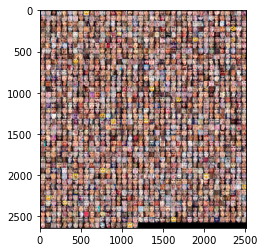

torch.Size([1500, 3, 64, 64])
angry: 0


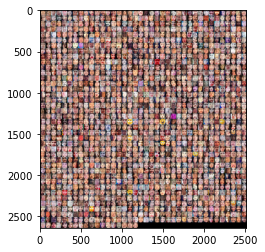

torch.Size([1500, 3, 64, 64])
clenched_teeth: 0


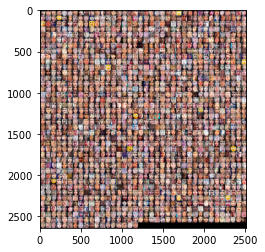

torch.Size([1500, 3, 64, 64])
cringe: 0


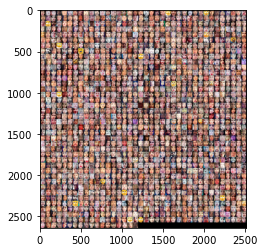

torch.Size([1500, 3, 64, 64])
disgust: 0


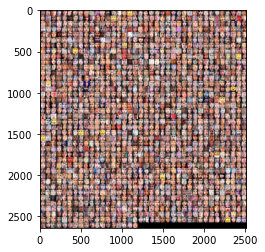

torch.Size([1500, 3, 64, 64])
eye_roll: 0


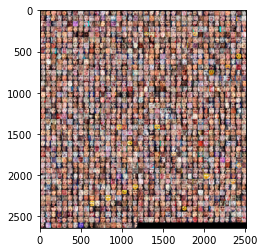

torch.Size([1500, 3, 64, 64])
here_we_go: 0


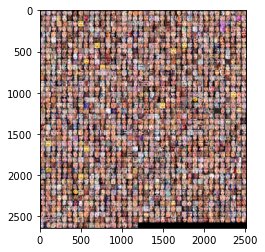

torch.Size([1500, 3, 64, 64])
kiss: 0


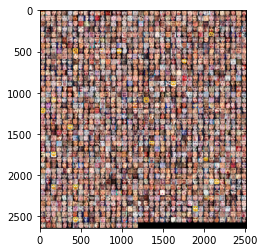

torch.Size([1500, 3, 64, 64])
sad: 0


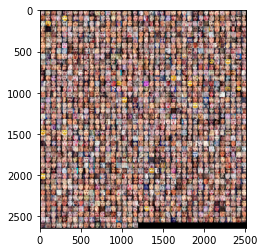

torch.Size([1500, 3, 64, 64])
surprise: 0


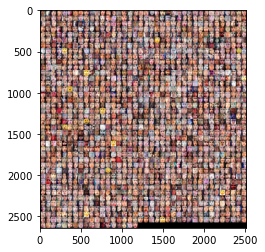

torch.Size([1500, 3, 64, 64])
very_sad: 0


In [10]:
n = 150
for key in idx_to_class: 
    save_emoji_images(key, n_images=1500)

In [11]:
root_dir = 'generated/'
avg = 0
not_faces = 0
# root_dir needs a trailing slash (i.e. /root/dir/)
for filename in glob.iglob(root_dir + '**/*.jpg', recursive=True):
    img = dlib.load_rgb_image(filename)
    try:
        dets, scores, idx = detector.run(img, 1, -1)
        avg += (sum(scores)/len(scores))/(n*n_classes)
        if (sum(scores)/len(scores)) < 0.27: 
            os.remove(filename)
    except: 
        not_faces += 1
        os.remove(filename)
print(avg)
print(not_faces)

3.3886237519022284
409


In [12]:
for folder in os.listdir('generated'):
    if os.path.isdir(os.path.join('generated', folder)):
        print(f'{folder}: {len(os.listdir(os.path.join("generated", folder)))}')

here_we_go: 816
kiss: 701
disgust: 862
cringe: 859
sad: 786
angry: 871
surprise: 862
clenched_teeth: 826
eye_roll: 787
very_sad: 843
